# Quadrant Scan 

The Quadrant Scan is a method based on recurrence plot that identify tipping points (change points) at which the system changes its behaviour (dynamic). The method is applicable on univariate and multivariate data.

The code below is for the Weighted Quadrant Scan (WQS). The inputs of the function are:
    
x : the data, a data frame with columns represent different variables for multivariate application, in this case the normalisation step is required.
    Or for univariate application, x is the embedded time series, in this case the normalisation step is not required.
    
alpha : is the recurrence threshold, it is a problem dependant parameter, good value to start with is 0.1
    
m1 and m2 : are the weighting parameters, also they are problem dependant, values to use (m1,m2)=(200,50), (100,25) or (50,10)

For referencing:

Zaitouny, A., Walker, D.M. and Small, M., 2019. Quadrant scan for multi-scale transition detection. Chaos: An Interdisciplinary Journal of Nonlinear Science, 29(10), p.103117.

Zaitouny, A., Small, M., Hill, J., Emelyanova, I. and Clennell, M.B., 2020. Fast automatic detection of geological boundaries from multivariate log data using recurrence. Computers & Geosciences, 135, p.104362.

# Import libraries and define functions

In [2]:
import scipy.io as sio
import time
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import scipy.sparse as sparse
from IPython.display import Latex
from matplotlib.pyplot import imshow



##Recurrence Plot matrix
## This function is constructing the recurrence plot matrix based on the threshold alpha. alpha is between 0 and 1.
def RecurrenceMatrix(x, alpha):
    
    distance = scipy.spatial.distance.pdist(x, 'euclidean')
    
    #Different norms for different applications
    
    #distance = scipy.spatial.distance.pdist(x, 'seuclidean',V=None) 
    #distance = scipy.spatial.distance.pdist(x, 'canberra')
    #distance = scipy.spatial.distance.pdist(x, 'mahalanobis', VI=None)
    
    distance = scipy.spatial.distance.squareform(distance)
    
    threshold = alpha*(distance.mean()+3*distance.std())
    
    #Recurrence Plot Matrix
    RM=np.array(distance<=threshold,dtype='int')
    
    return RM


## Normalisation
## This function is for normalising the columns in a multivariate input which is important to avoid dominance
## of variable with larger scale
## This step is not required for univariate application and embedded time series
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result


##Quadrant Scan
## This function is employing the Quadrant Scan technique on input x (univariate or multivariate) using:
## the recuurence plot threshold alpha, the weighting parameters m1 and m2.

def WeightQS2(x, alpha, m1, m2):
    
    x = normalize(x)  # not required for embedded time series
    x = np.array(x)
    
    z = np.array(x[:20])
    np.random.shuffle(z)
    x = np.append(z, x, axis=0)
    z = np.array(x[len(x)-20:len(x)])
    np.random.shuffle(z)
    x = np.append(x, z, axis=0)
    x = np.array(x)
    
    RM=RecurrenceMatrix(x, alpha)
    
    qs=np.zeros(len(x))
    for ii in range(1, len(x)):
        weightp = 0.5*(1-np.tanh((np.arange(1,ii+1)-m1)/m2))
        weightp = weightp[::-1]
        weightf = 0.5*(1-np.tanh((np.arange(1,len(x)-ii+1)-m1)/m2))
        
        weightpp = weightp[:,None]*weightp[None,:]
        weightpp = weightpp/weightpp[-1,-1]
        
        weightff = weightf[:,None]*weightf[None,:]
        weightff = weightff/weightff[0,0]
        
        weightpf=weightp[:,None]*weightf[None,:]
        weightpf /= weightpf[-1,0]
        
        weightfp=weightf[:,None]*weightp[None,:]
        weightfp /= weightfp[0,-1]
       
        pp =  RM[:ii,:ii] * weightpp
        
        ff = RM[ii-1:-1,ii-1:-1] * weightff
        
        pf = RM[:ii,ii-1:-1] * weightpf
        
        fp = RM[ii-1:-1,:ii] * weightfp
        
        qs1 = np.sum(pp)+np.sum(ff)
        qs2 = np.sum(pf)+np.sum(fp)
        qs[ii] = qs1/(qs1+qs2)
        
    return qs[20:len(qs)-20]


## Simple artificial example for demonstration

In [3]:
# Creating a 2D dataframe at which each feature shows a transition in different time

x1 = np.random.rand(100)+3
x2 = np.random.rand(100)+5

x = np.concatenate((x1, x2)) # first column

y1 = np.random.rand(150)+8
y2 = np.random.rand(50)+2

y = np.concatenate((y1, y2)) # second column

df = pd.DataFrame({'Feature1': x, 'Feature2' : y }) # the dataframe

df.head()

,Feature1,Feature2
0,3.289313,8.638734
1,3.607416,8.194835
2,3.204970,8.583170
3,3.767367,8.788211
4,3.414003,8.428857


In [4]:
## implementing the weighted quadrant scan

wqs = WeightQS2(df, 0.1, 100, 25)

<function matplotlib.pyplot.show(close=None, block=None)>

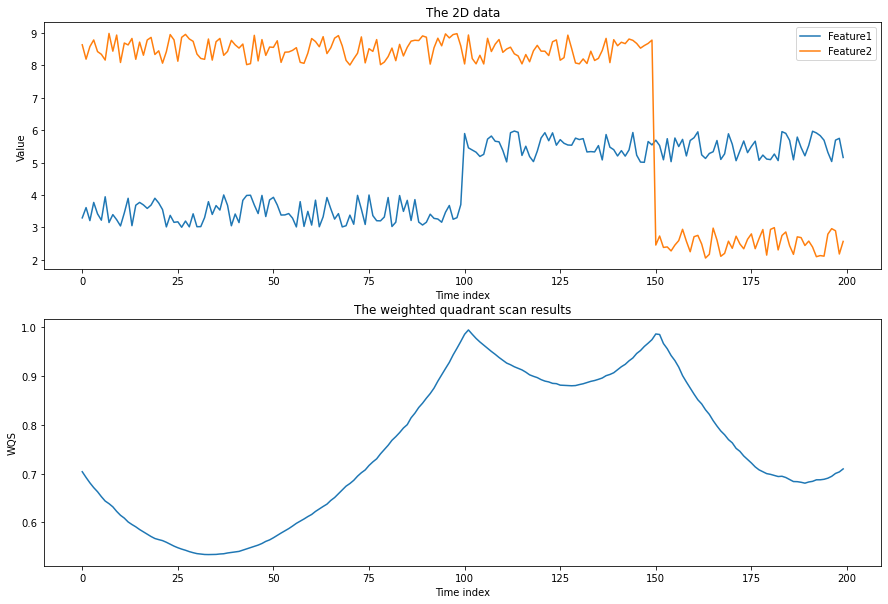

In [5]:
## Plot the data and the wqs for demonstration

fig, ax = plt.subplots(2,1,figsize=(15,10))
ax[0].plot(df['Feature1'] , label = 'Feature1')
ax[0].plot(df['Feature2'], label = 'Feature2')
ax[0].set_xlabel('Time index')
ax[0].set_ylabel('Value')
ax[0].set_title('The 2D data')
ax[0].legend()
ax[1].plot(wqs)
ax[1].set_xlabel('Time index')
ax[1].set_ylabel('WQS')
ax[1].set_title('The weighted quadrant scan results')
plt.show

# Detect lithological boundaries using Quadrant Scan

In this notebook, we will test the Quadrant Scan technique to analyse a multivariate, noisy, and nonstationary data set.

The data set includes petrophysical profiles from well_log measures. Namely, DTCO, ECGR, HART, PEFZ, RHOZ, TNPH.
The data includes 7688 depth samples. Refering to the following petrophysical profiles density, electrical resistivity, sonic velocity, natural radioactivity, mean atomic number and neutron porosity

We have added a column to the data set (last column: "Geological layer") in which we gave a number to each layer type as identified by the geologists.

The idea of this exercise is to use the Quadrant Scan to detect transision in the data profiles to identify the lithological boundaries.

# Reading the data file

In [6]:
Petrophysical_data = pd.read_csv('../data/Petrophysical_data.csv')  ## Reading the data set file, fix the directory

In [7]:
Petrophysical_data.head()  ## Have a look at the data

,DEPTH,DTCO,ECGR,HART,PEFZ,RHOZ,TNPH,Gelogical layer
0,2207.057,73.166,36.884,2.016,4.214,2.437,0.149,1
1,2207.209,74.623,39.817,1.821,4.212,2.438,0.156,1
2,2207.362,74.979,42.094,1.758,4.182,2.434,0.163,1
3,2207.514,73.891,39.149,1.700,4.088,2.429,0.171,1
4,2207.666,74.385,36.679,1.641,3.980,2.421,0.172,1


In [8]:
xx = pd.DataFrame(Petrophysical_data[['DTCO','ECGR']]) ## Select two columns from the data file
xx.head()

,DTCO,ECGR
0,73.166,36.884
1,74.623,39.817
2,74.979,42.094
3,73.891,39.149
4,74.385,36.679


# Implement the Quadrant Scan

There are three paramteres to set up. 
alpha --> the recurrence plot threshold, this can be varied for multiscale detection, Good choice for the data at hand is 0.2
m1, m2 are the weighting scheme parameters as demonstrated in the slides, an appropraite setting for the the data at hand is m1=200, m2=50. You could try different settings such as m1=100, m2=25 or m1=50, m2=10

## Input a single variable

Choose one variable and run the Quadrant Scan for 2000 depth samples (between depth index 1000 to depth index 3000)

Here, We chose ECGR - Gamma Ray

In [9]:
x1 = pd.DataFrame(Petrophysical_data[['ECGR']]) ## select a variable from the data set
QS1 = WeightQS2(x1[1000:3000], 0.2, 200, 50) ## Run the Quadrant Scan on the selected column (variable)

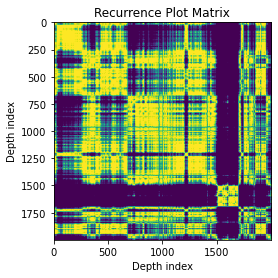

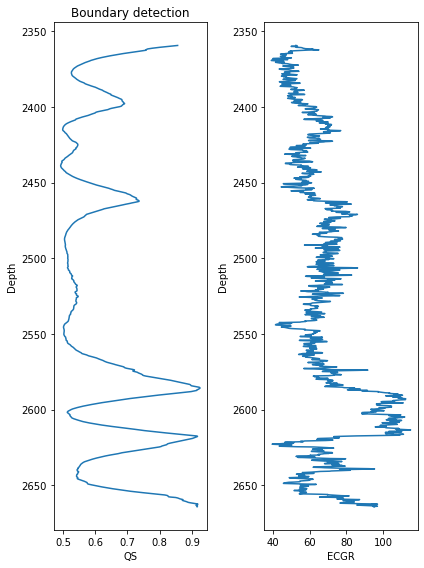

In [10]:
## Plotting the resulted Quadrant Scan with the input data.

RM = RecurrenceMatrix(x1[1000:3000], 0.2) ## Estimating the recurrence plot matrix for demonstration.
## You can change the parameter alpha to see how it effects the recurrence plot matrix. (alpha is between 0 to 1)

f1 = plt.figure() ## plot the recurrence plot matrix
imshow(np.asarray(RM))
plt.title('Recurrence Plot Matrix')
plt.xlabel('Depth index')
plt.ylabel('Depth index')

f2 = plt.figure(figsize=(6,8)) ## plot the Quadrant Scan and the input data
plt.subplot(1, 2, 1)
plt.plot(QS1, np.array(Petrophysical_data['DEPTH'][1000:3000]))
plt.gca().invert_yaxis()
plt.title('Boundary detection')
plt.xlabel('QS')
plt.ylabel('Depth')

plt.subplot(1, 2, 2)
plt.plot(np.array(Petrophysical_data['ECGR'][1000:3000]), np.array(Petrophysical_data['DEPTH'][1000:3000]))
plt.gca().invert_yaxis()
plt.xlabel('ECGR')
plt.ylabel('Depth')

f2.tight_layout()

## Now try for another variable 
Choose another variable and run the Quadrant Scan for 2000 depth samples (between depth index 1000 to depth index 3000)

Here, We chose HART - Resistivity

In [11]:
x2 = pd.DataFrame(Petrophysical_data[['HART']]) ## select a variable from the data set
QS2 = WeightQS2(x2[1000:3000], 0.2, 200, 50) ## Run the Quadrant Scan on the selected column (variable)

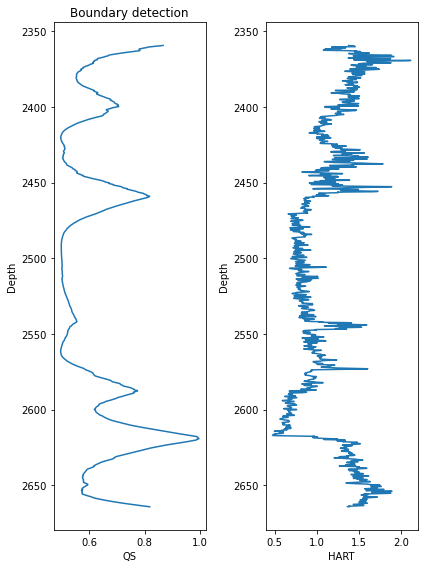

In [12]:
## Plotting the resulted Quadrant Scan with the input data.

f1 = plt.figure(figsize=(6,8))

plt.subplot(1, 2, 1)
plt.plot(QS2, np.array(Petrophysical_data['DEPTH'][1000:3000]))
plt.gca().invert_yaxis()
plt.title('Boundary detection')
plt.xlabel('QS')
plt.ylabel('Depth')

plt.subplot(1, 2, 2)
plt.plot(np.array(Petrophysical_data['HART'][1000:3000]), np.array(Petrophysical_data['DEPTH'][1000:3000]))
plt.gca().invert_yaxis()
plt.xlabel('HART')
plt.ylabel('Depth')

f1.tight_layout()

## Compare the detections from different profiles

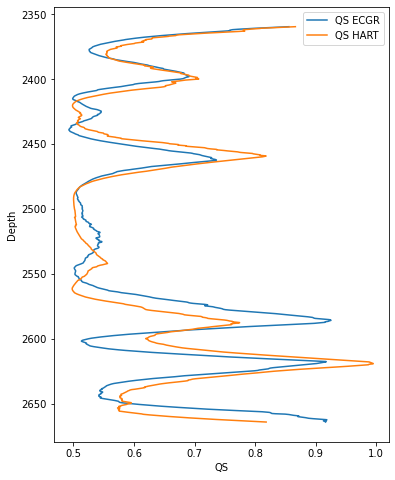

In [13]:
## Plotting the resulted Quadrant Scan with the input data.
f1 = plt.figure(figsize = (6,8))
plt.plot(QS1, np.array(Petrophysical_data['DEPTH'][1000:3000]), label="QS ECGR")
plt.plot(QS2, np.array(Petrophysical_data['DEPTH'][1000:3000]), label="QS HART")
plt.gca().invert_yaxis()
plt.xlabel('QS')
plt.ylabel('Depth')
plt.legend()
plt.show()

## Now combine the variables and use multivariate input
Let us start combining the profiles we used above.

In [14]:
x3 = pd.DataFrame(Petrophysical_data[['HART','ECGR']]) ## Select multiple variables
QS3 = WeightQS2(x3[1000:3000], 0.2, 200, 50)  ## Run the Quadrant Scan on the selected columns (variables)

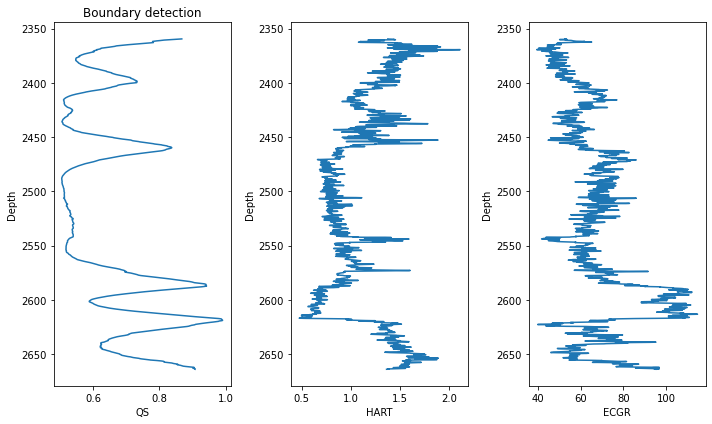

In [15]:
## Plotting the resulted Quadrant Scan with the input data.

f2 = plt.figure(figsize = (10,6))

plt.subplot(1, 3, 1)
plt.plot(QS3, np.array(Petrophysical_data['DEPTH'][1000:3000]))
plt.gca().invert_yaxis()
plt.title('Boundary detection')
plt.xlabel('QS')
plt.ylabel('Depth')

plt.subplot(1, 3, 2)
plt.plot(np.array(Petrophysical_data['HART'][1000:3000]), np.array(Petrophysical_data['DEPTH'][1000:3000]))
plt.gca().invert_yaxis()
plt.xlabel('HART')
plt.ylabel('Depth')

plt.subplot(1, 3, 3)
plt.plot(np.array(Petrophysical_data['ECGR'][1000:3000]), np.array(Petrophysical_data['DEPTH'][1000:3000]))
plt.gca().invert_yaxis()
plt.xlabel('ECGR')
plt.ylabel('Depth')

f2.tight_layout()

## Compare the results

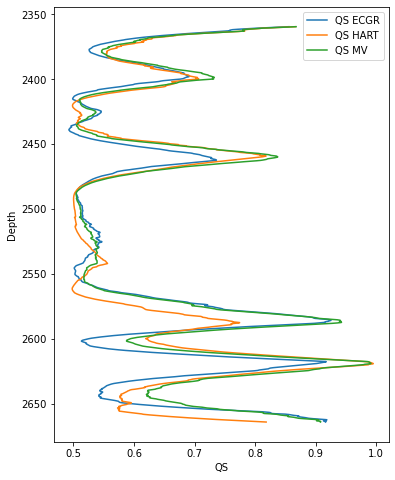

In [16]:
## Plotting the Quadrant curves for comparison.
f1 = plt.figure(figsize = (6,8))
plt.plot(QS1, np.array(Petrophysical_data['DEPTH'][1000:3000]), label="QS ECGR")
plt.plot(QS2, np.array(Petrophysical_data['DEPTH'][1000:3000]), label="QS HART")
plt.plot(QS3, np.array(Petrophysical_data['DEPTH'][1000:3000]), label="QS MV")
plt.gca().invert_yaxis()
plt.xlabel('QS')
plt.ylabel('Depth')
plt.legend()
plt.show()

## Multiscale detection:
Test the performance by varying the Recurrence Plot threshold (alpha) from larger value to smaller value:

Say from alpha=0.6 to 0.1

You can test using univariate or multivariate input

In [17]:
## Evaluate the Quadrant Scan for different thresholds.

MS_QS6 = WeightQS2(x1[2000:3000], 0.6, 200, 50)
MS_QS5 = WeightQS2(x1[2000:3000], 0.5, 200, 50)
MS_QS4 = WeightQS2(x1[2000:3000], 0.4, 200, 50)
MS_QS3 = WeightQS2(x1[2000:3000], 0.3, 200, 50)
MS_QS2 = WeightQS2(x1[2000:3000], 0.2, 200, 50)
MS_QS1 = WeightQS2(x1[2000:3000], 0.1, 200, 50)

## Plotting for comparison

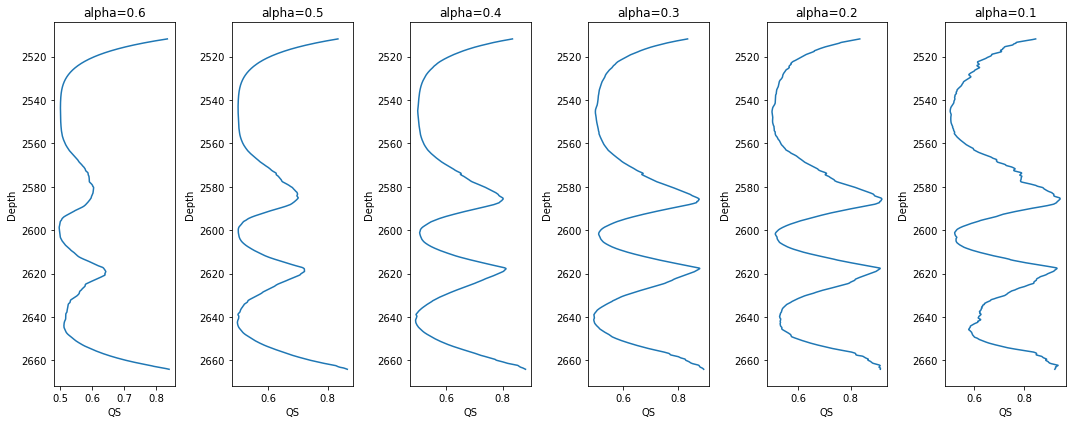

In [18]:
## Plotting the resulted Quadrant Scan curves for each threshold.

f3 = plt.figure(figsize=(15,6))

plt.subplot(1, 6, 1)
plt.plot(MS_QS6, np.array(Petrophysical_data['DEPTH'][2000:3000]))
plt.gca().invert_yaxis()
plt.title('alpha=0.6')
plt.xlabel('QS')
plt.ylabel('Depth')

plt.subplot(1, 6, 2)
plt.plot(MS_QS5, np.array(Petrophysical_data['DEPTH'][2000:3000]))
plt.gca().invert_yaxis()
plt.title('alpha=0.5')
plt.xlabel('QS')
plt.ylabel('Depth')

plt.subplot(1, 6, 3)
plt.plot(MS_QS4, np.array(Petrophysical_data['DEPTH'][2000:3000]))
plt.gca().invert_yaxis()
plt.title('alpha=0.4')
plt.xlabel('QS')
plt.ylabel('Depth')

plt.subplot(1, 6, 4)
plt.plot(MS_QS3, np.array(Petrophysical_data['DEPTH'][2000:3000]))
plt.gca().invert_yaxis()
plt.title('alpha=0.3')
plt.xlabel('QS')
plt.ylabel('Depth')

plt.subplot(1, 6, 5)
plt.plot(MS_QS2, np.array(Petrophysical_data['DEPTH'][2000:3000]))
plt.gca().invert_yaxis()
plt.title('alpha=0.2')
plt.xlabel('QS')
plt.ylabel('Depth')

plt.subplot(1, 6, 6)
plt.plot(MS_QS1, np.array(Petrophysical_data['DEPTH'][2000:3000]))
plt.gca().invert_yaxis()
plt.title('alpha=0.1')
plt.xlabel('QS')
plt.ylabel('Depth')

f3.tight_layout()